In [8]:
import scipy as scp

In [9]:
from scipy import special

In [10]:
import numpy as np

In [12]:
from tqdm import tqdm_notebook

In [13]:
import matplotlib.gridspec as gridspec

In [126]:
from sklearn.metrics import silhouette_score

In [127]:
from sklearn.cluster import KMeans

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

### Extraction des données

##### Binary Alpha Digits

Import du fichier .mat

référence : https://docs.scipy.org/doc/scipy/reference/tutorial/io.html

In [15]:
import scipy.io as sio

In [16]:
classlabels = sio.loadmat('binaryalphadigs.mat')['classlabels'][0]
np.save('BAD_classlabels.npy',classlabels)

In [17]:
dat = sio.loadmat('binaryalphadigs.mat')['dat']
np.save('BinaryAlphaDigs.npy',dat)

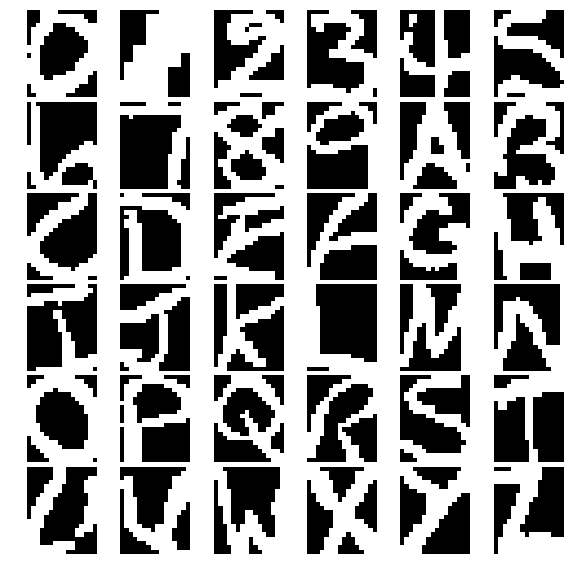

In [18]:
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(len(dat)):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(dat[i,np.random.randint(0,len(dat[i])-1)],cmap=plt.cm.gray)
    
plt.show()

##### MNIST

from : https://stackoverflow.com/a/53181925

In [19]:
import struct

In [20]:
def read_images(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
    np.save(filesave,data)

In [21]:
def read_labels(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f,dtype=np.dtype(np.uint8))
    np.save(filesave,labels)

In [22]:
read_images('../MNIST/t10k-images-idx3-ubyte','MNIST_test_images.npy')
read_images('../MNIST/train-images-idx3-ubyte','MNIST_train_images.npy')

In [23]:
read_labels('../MNIST/t10k-labels-idx1-ubyte','MNIST_test_labels.npy')
read_labels('../MNIST/train-labels-idx1-ubyte','MNIST_train_labels.npy')

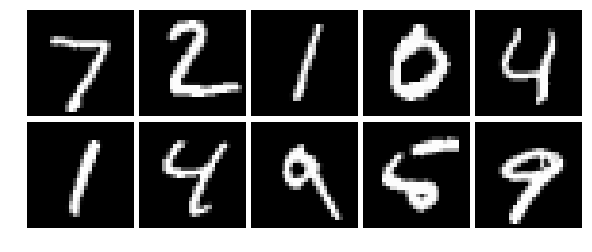

In [28]:
plt.figure(figsize = (10,4))
gs1 = gridspec.GridSpec(2, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(10):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(MNIST_test_images[i,:,:],cmap=plt.cm.gray)
    
plt.show()

### Reading npy files

In [26]:
AD = np.load('BinaryAlphaDigs.npy')
AD_labels = np.load('BAD_classlabels.npy')

In [25]:
MNIST_test_images = np.load("MNIST_test_images.npy")
MNIST_test_labels = np.load("MNIST_test_labels.npy")
MNIST_train_images = np.load("MNIST_train_images.npy")
MNIST_train_labels = np.load("MNIST_train_labels.npy")

# 3.1 Construction d'un RBM et test sur Binary AlphaDigits

In [30]:
def lire_alpha_digit(char_list=None):
    
    AD = np.load('BinaryAlphaDigs.npy')
    AD_labels = np.load('BAD_classlabels.npy')
    
    array_list = []
    labels = []
    
    char_list = char_list or AD_labels
    
#     print(char_list.astype(str))
    
    for c in np.core.defchararray.upper([*char_list]):
        
        idx = np.where(AD_labels==c)[0][0]
        AD_char = np.array([*AD[idx,:]])
        
        n = AD_char.shape[0]
        m = AD_char.shape[1]*AD_char.shape[2]
        
        AD_r = AD_char.reshape([n,m])
        
        array_list.append(AD_r)
        labels.extend([c]*n)
        
    return np.concatenate(array_list),np.array(labels)

In [82]:
X_6,lab_6 = lire_alpha_digit(['6'])

In [32]:
X,lab = lire_alpha_digit()

In [33]:
class RBM:
    
    f_act = special.expit
    
    def __init__(self,v_size=320,h_size=10,A=None,B=None,W=None):
        
        self.v_size=v_size
        self.h_size=h_size
        
        self.A = A or np.zeros(v_size)[:,None]
        self.B = B or np.zeros(h_size)[:,None]
        self.W = W or np.random.normal(scale=0.1,size=(h_size,v_size))
        
    def forward(self,x):
        
        if len(x.shape) == 1:
            return self.f_act(self.B + np.dot(self.W,x)[:,None])
        else:
            return self.f_act(np.tile(self.B,(1,x.shape[1])) + np.dot(self.W,x))
    
    def backward(self,y):
        
        if len(y.shape) == 1:
            return self.f_act(self.A + np.dot(self.W.T,y)[:,None])
        else:
            return self.f_act(np.tile(self.A,(1,y.shape[1])) + np.dot(self.W.T,y))
    
    def contrastive_divergence_1(self,x):
        
        proba_h_x = self.forward(x)
        h_0 = np.random.binomial(1,proba_h_x)
        
        proba_v_h = self.backward(h_0)
        v_1 = np.random.binomial(1,proba_v_h)
        
        proba_h_v = self.forward(v_1)
        
        return proba_h_x,proba_v_h,v_1,proba_h_v
    
    def train(self,X,n_epochs=20,l_r=1.0,batch_size=32,lr_decay=0.5,cold_start=True):
        
        if cold_start:
            
            self.A = np.zeros(self.v_size)[:,None]
            self.B = np.zeros(self.h_size)[:,None]
            self.W = np.random.normal(scale=0.1,size=(self.h_size,self.v_size))
        
        self.erreur = []
        n = X.shape[0]
        
        for k in tqdm_notebook(range(n_epochs),desc='Epochs'):
        
            X_temp = X.copy()
            np.random.shuffle(X_temp)

            for i in range(int(np.ceil(n/batch_size))):

                i_next = (i+1)*batch_size
                end = n if i_next > n else i_next
                
                X_batch = X_temp[i*batch_size:end,:].T
                Phx,Pvh,v1,Phv = self.contrastive_divergence_1(X_batch)
                
                dW = np.dot(Phx,X_batch.T) - np.dot(Phv,v1.T)
                dA = np.sum(X_batch,1) - np.sum(v1,1)
#                 dA = np.sum(X_batch - v1,1)
                dB = np.sum(Phx,1) - np.sum(Phv,1)
#                 dB = np.sum(Phx - Phv,1)
                
                self.W += l_r*dW
                self.A += l_r*dA[:,None]
                self.B += l_r*dB[:,None]

#                 if i == np.ceil(n/batch_size)-1:
                self.erreur.append(((X_batch - v1)**2).mean())
#                 self.erreur.append(1/(i_next-i)*np.sum(np.linalg.norm(Pvh-X_batch)))
                
            l_r *= lr_decay
            
    def show_erreur(self):
        
        plt.plot(self.erreur)
        plt.show()
        
    def show_random_init(self,n_trial=5):
        
        V = np.random.normal(size=(self.A.shape[0],1))
        out = self.backward(self.forward(V))
        for i in range(n_trial-1):
            out = self.backward(self.forward(out))
        plt.imshow(np.reshape(out,(20,16)),cmap='gray')
        plt.show()
        
    def create_canonical_vector(shape,i):
        
        H = np.zeros(shape=shape)
        H[i] = 1
        return H
        
    def show_canonical(self):
        
        n = self.B.shape[0]
        
        vec_can = [RBM.create_canonical_vector(self.B.shape,i) for i in range(n)]
        
        self.show_from_vectors(vec_can)
        
#         plt.figure(figsize=(n_cols*2,n//2))
#         gs1 = gridspec.GridSpec(int(np.ceil(n/n_cols)), n_cols)
#         gs1.update(wspace=0.025, hspace=0.025)

#         for i in range(n):

#             ax = plt.subplot(gs1[i])
#             ax.axis('off')
#             H = np.zeros(shape=self.B.shape)
#             H[i] = 1
#             out = self.backward(H)
#             ax.imshow(np.reshape(out,(20,16)),cmap='gray')
            
#         plt.show()
        
    def show_from_canonical_h(self,i):
        
        H = np.zeros(shape=self.B.shape)
        H[i] = 1
        out = self.backward(H)
        plt.imshow(np.reshape(out,(20,16)),cmap='gray')
        plt.show()
        
    def determine_mean_vectors(self,X,lab):
        
        vectors = self.determine_out_vectors(X,lab)
    
        return {k:np.mean(v,axis=1,keepdims=True) for k,v in vectors.items()}
    
    def determine_clusters(self,X,lab,n_clusters_range=range(30,50)):
        
        vectors = self.determine_out_vectors(X,lab)
        
        vectors_array = np.concatenate([*vectors.values()],axis=1).T
        
        s_dict = {}
        
        for n in n_clusters_range:
        
            KM = KMeans(n,n_jobs=-1)
            KM.fit(vectors_array)
            labels = KM.labels_
            ss = silhouette_score(X,labels,metric='euclidean')
            s_dict[n] = ss
            
        n_opt = max(s_dict, key=s_dict.get)
        KM = KMeans(n_opt,n_jobs=-1)
        KM.fit(vectors_array)
        return KM.labels_
    
    def show_clusters(self,X,lab):
        
        k_means_labels = self.determine_clusters(X,lab)
            
        self.show_from_vectors({k:np.mean(v,axis=1,keepdims=True) for k,v in self.determine_out_vectors(X,k_means_labels).items()})
    
    def determine_out_vectors(self,X,lab):
        
        vectors = {}
        
        for l in np.unique(lab):
            
            idx = np.where(lab==l)[0]
            X_c = np.array([*X[idx,:]])
            
            vectors[l] = self.forward(X_c.T)
    
        return vectors
    
    def show_from_vectors(self,vectors,n_cols=5):
                
        n = len(vectors)
        
        plt.figure(figsize=(n_cols*2,n//2))
        gs1 = gridspec.GridSpec(int(np.ceil(n/n_cols)), n_cols)
        gs1.update(wspace=0.025, hspace=0.025)

        for i,v in enumerate(vectors):

            ax = plt.subplot(gs1[i])
            ax.axis('off')
            out = self.backward(vectors[i])
            ax.imshow(np.reshape(out,(20,16)),cmap='gray')
            
        plt.show()

In [167]:
R = RBM(h_size=40)

In [168]:
R.train(X,batch_size=10,n_epochs=40,l_r=0.1,lr_decay=0.5)

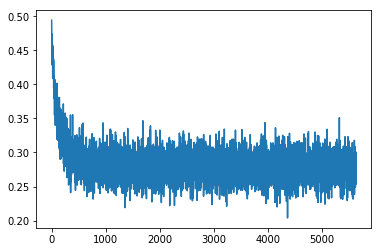

In [169]:
R.show_erreur()

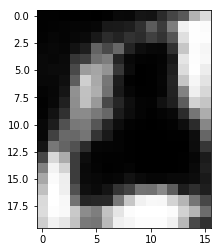

In [193]:
R.show_random_init(1000)

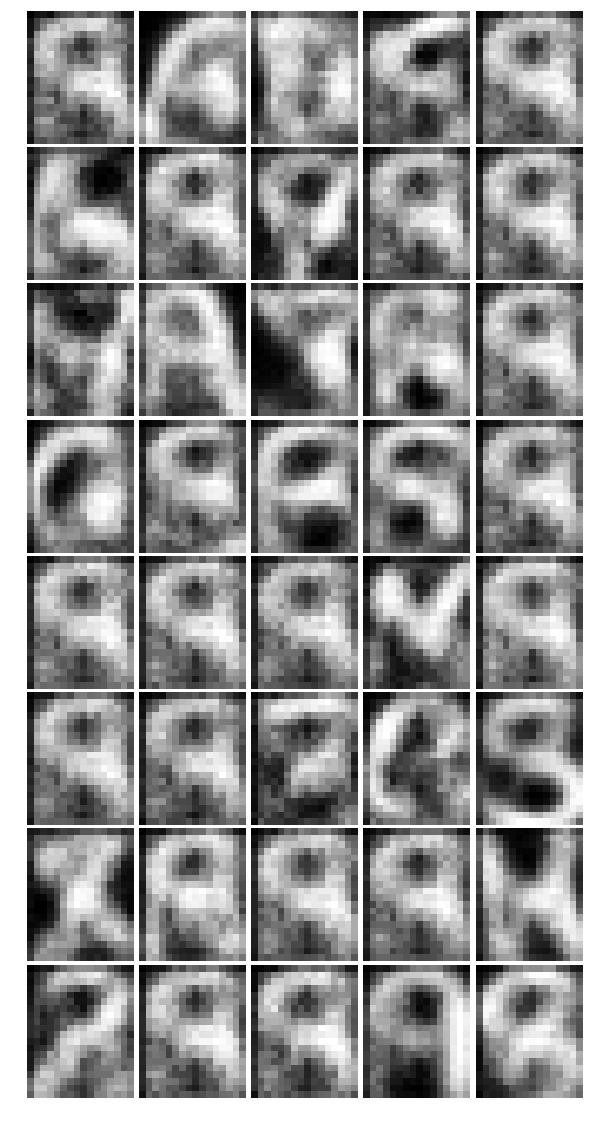

In [171]:
R.show_canonical()

In [172]:
vec = R.determine_mean_vectors(X,lab)

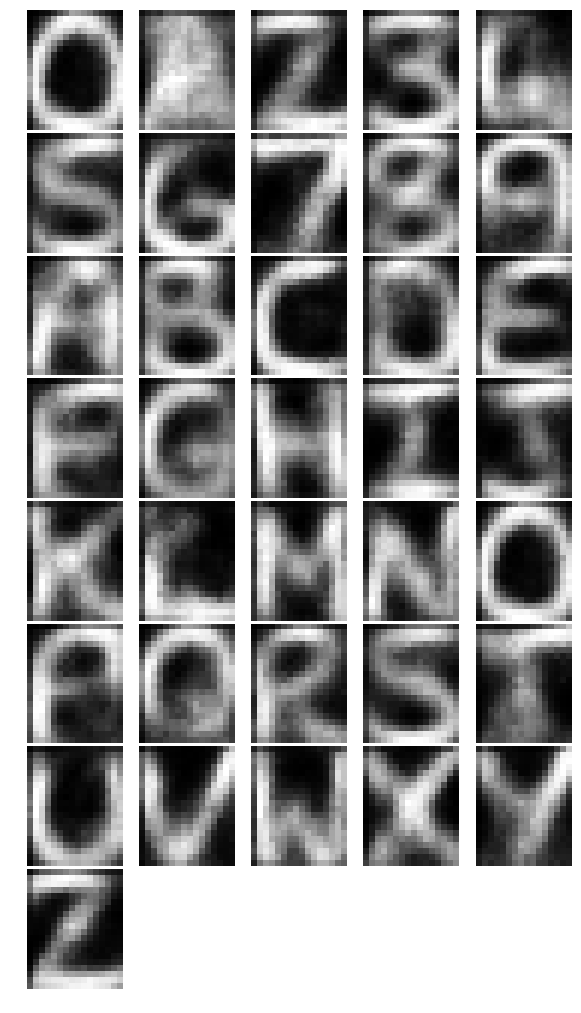

In [173]:
R.show_from_vectors([*vec.values()])

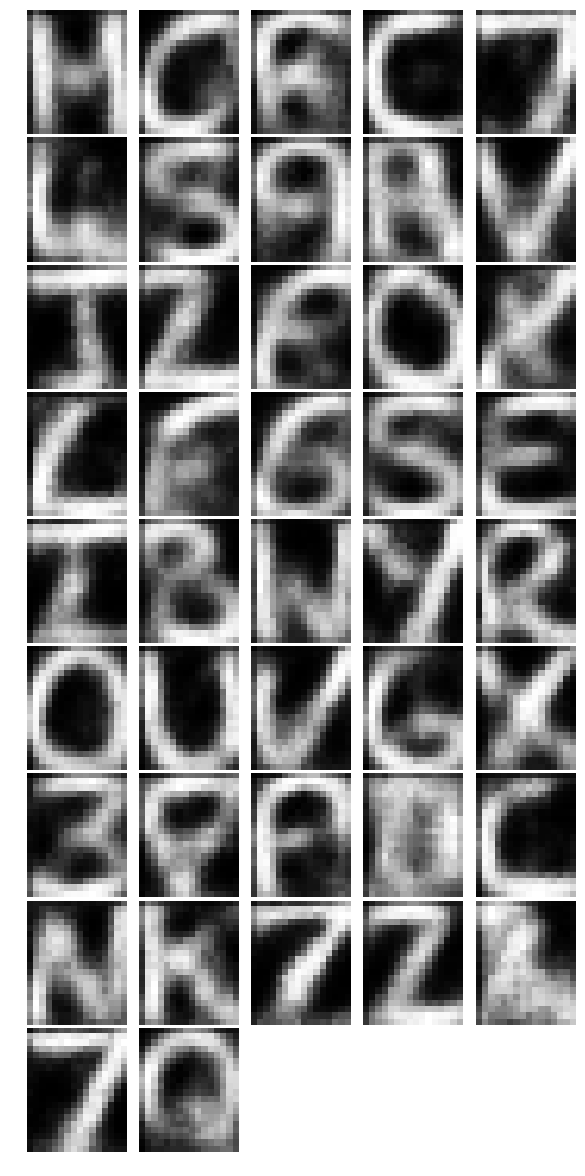

In [176]:
R.show_clusters(X,lab)

# 3.2 Construction d'un DBN et test sur Binary AlphaDigits

In [188]:
class RBM_prop(RBM):
    
    def __init__(self,**kwargs):
        
        super().__init__(**kwargs)
        
    def forward(self,x):
        
        if len(x.shape) == 1:
            self.l = self.f_act(self.B + np.dot(self.W,x)[:,None])
        else:
            self.l = self.f_act(np.tile(self.B,(1,x.shape[1])) + np.dot(self.W,x))
            
        return self.l

In [192]:
class DBN:
    
    def __init__(self,size_layers):
        
        self.RBMS = [RBM_prop(v_size=size_layers[i],h_size=size_layers[i+1]) for i in range(len(size_layers)-1)]
        
    def forward(self,x):
        
        for RBM in self.RBMS:
            
            x = RBM.forward(x)
            
        return x
    
    def backward(self,x):
        
        for RBM in self.RBMS[::-1]:
            
            x = RBM.backward(x)
            
        return x
    
    def pre_train(self,x,**kwargs):
        
        for RBM in self.RBMS:
            
            RBM.train(x,**kwargs)
            x = RBM.forward(x.T).T
            
    def show_random_init(self,n_trial=5):
        
        V = np.random.normal(size=(self.RBMS[0].A.shape[0],1))
        out = self.backward(self.forward(V))
        for i in range(n_trial-1):
            out = self.backward(self.forward(out))
        plt.imshow(np.reshape(out,(20,16)),cmap='gray')
        plt.show()
        
    def show_erreur(self):
        
        for RBM in self.RBMS:
            
            plt.plot(RBM.erreur)
        
        plt.show()
        
    def determine_out_vectors(self,X,lab):
        
        vectors = {}
        
        for l in np.unique(lab):
            
            idx = np.where(lab==l)[0]
            X_c = np.array([*X[idx,:]])
            
            vectors[l] = self.forward(X_c.T)
    
        return vectors
        
    def determine_clusters(self,X,lab,n_clusters_range=range(30,50)):
        
        vectors = self.determine_out_vectors(X,lab)
        
        vectors_array = np.concatenate([*vectors.values()],axis=1).T
        
        s_dict = {}
        
        for n in n_clusters_range:
        
            KM = KMeans(n,n_jobs=-1)
            KM.fit(vectors_array)
            labels = KM.labels_
            ss = silhouette_score(X,labels,metric='euclidean')
            s_dict[n] = ss
            
        n_opt = max(s_dict, key=s_dict.get)
        KM = KMeans(n_opt,n_jobs=-1)
        KM.fit(vectors_array)
        return KM.labels_
    
    def show_clusters(self,X,lab):
        
        k_means_labels = self.determine_clusters(X,lab)
            
        self.show_from_vectors({k:np.mean(v,axis=1,keepdims=True) for k,v in self.determine_out_vectors(X,k_means_labels).items()})
        
    def show_from_vectors(self,vectors,n_cols=5):
                
        n = len(vectors)
        
        plt.figure(figsize=(n_cols*2,n//2))
        gs1 = gridspec.GridSpec(int(np.ceil(n/n_cols)), n_cols)
        gs1.update(wspace=0.025, hspace=0.025)

        for i,v in enumerate(vectors):

            ax = plt.subplot(gs1[i])
            ax.axis('off')
            out = self.backward(vectors[i])
            ax.imshow(np.reshape(out,(20,16)),cmap='gray')
            
        plt.show()

In [190]:
size_layers = [320,240,128,36]

In [181]:
size_layers = [320,240,128,64,45]

In [193]:
dbn = DBN(size_layers)

In [194]:
dbn.pre_train(x=X,batch_size=10,n_epochs=20,l_r=1e-2,lr_decay=0.7)

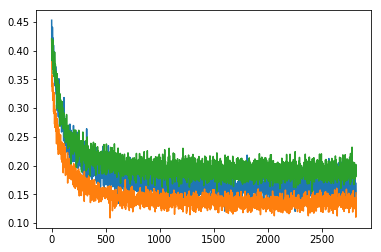

In [195]:
dbn.show_erreur()

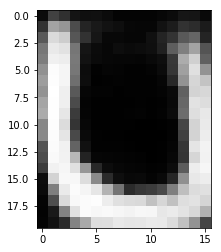

In [196]:
dbn.show_random_init()

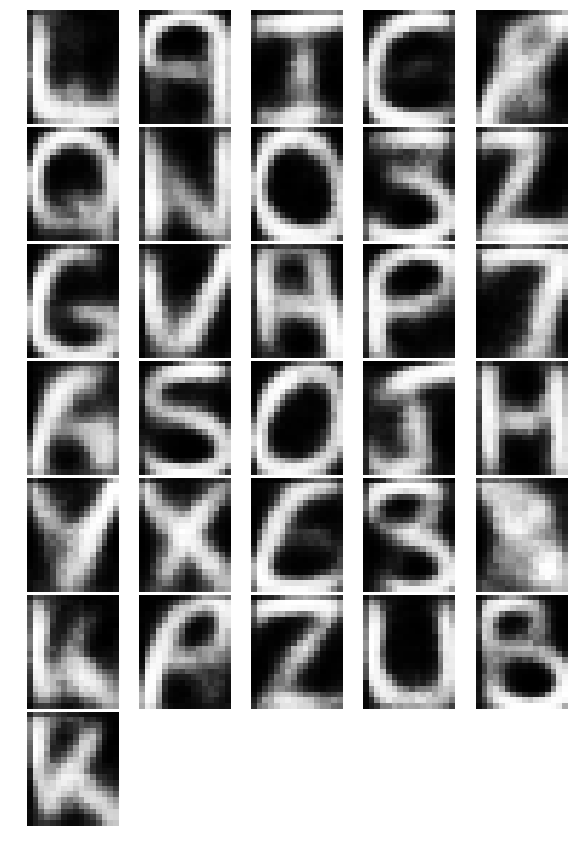

In [197]:
dbn.show_clusters(X,lab)

# 3.3 Construction d'un DNN et test sur MNIST

In [211]:
def softmax(X):
    
    return np.exp(X) / np.sum(np.exp(X),axis=1,keepdims=True)

In [ ]:
def cross_entropy(X,Y):
    
    return np

In [ ]:
class DNN(DBN):
    
    def __init__(self,**kwargs):
        
        super().__init__(**kwargs)
        
    def predict(self,X_batch):
        
        return softmax(self.forward(X_batch))
        
    def backprop(self,X_batch,Y):
        
        Y_hat = self.predict(X_batch)
        
        
                
        
    def train(self,X,Y,args_pretrain,n_epochs=20,l_r=1.0,batch_size=32,lr_decay=0.5):
        
        self.pre_train(X,**args_pretrain)
        
        for k in tqdm_notebook(range(n_epochs),desc='Epochs'):
        
            X_temp = X.copy()
            np.random.shuffle(X_temp)

            for i in range(int(np.ceil(n/batch_size))):

                i_next = (i+1)*batch_size
                end = n if i_next > n else i_next
                
                X_batch = X_temp[i*batch_size:end,:].T
                Phx,Pvh,v1,Phv = self.contrastive_divergence_1(X_batch)
                
                dW = np.dot(Phx,X_batch.T) - np.dot(Phv,v1.T)
                dA = np.sum(X_batch,1) - np.sum(v1,1)
#                 dA = np.sum(X_batch - v1,1)
                dB = np.sum(Phx,1) - np.sum(Phv,1)
#                 dB = np.sum(Phx - Phv,1)
                
                self.W += l_r*dW
                self.A += l_r*dA[:,None]
                self.B += l_r*dB[:,None]

#                 if i == np.ceil(n/batch_size)-1:
                self.erreur.append(((X_batch - v1)**2).mean())
#                 self.erreur.append(1/(i_next-i)*np.sum(np.linalg.norm(Pvh-X_batch)))
                
            l_r *= lr_decay